In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os

In [261]:
font_path = ["C/Users/Paweł/Exercises/Power BI/PGE Ekstraliga/Fonts"]
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

TypeError: listdir: path should be string, bytes, os.PathLike or None, not list

In [262]:
font_dirs = ["C/Users/Paweł/Exercises/Power BI/PGE Ekstraliga/Fonts"]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

In [3]:
barwy = {
    'Zmarzlik Bartosz': {
        'low': '#6aaa96',
        'high': '#f7ea72'
    },
    'Pedersen Nicki': {
        'low': '#00B2A9',
        'high': '#ea7e55'
    },
    'Kołodziej Janusz': {
        'low': '#d1d3d4',
        'high': '#034694'
    },
    'Madsen Leon': {
        'low': '#ffbee9',
        'high': '#6ab4ee'
    },
    'Vaculik Martin': {
        'low':'#6d6aa8',
        'high':'#f4777f'
    },
    'Pawlicki Piotr':{
        'low':'#e2422e',
        'high':'#8bcf71'
    },
    'Janowski Maciej':{
        'low':'#ff9b7a',
        'high':'#760038'
    },
    'Hampel Jarosław':{
        'low':'#fdbe11',
        'high':'#0053a0'
    },
    'Holder Chris':{
        'low':'#b2c5ff',
        'high':'#00285e'
    },
}

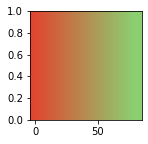

In [4]:
def colorFader(c1, c2, mix=0):
    c1 = np.array(mcolors.to_rgb(c1))
    c2 = np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix)*c1 + mix*c2)
c1 = barwy['Pawlicki Piotr']['low']
c2 = barwy['Pawlicki Piotr']['high']
n=83

fig, ax = plt.subplots(figsize=(2,2))
for x in range(n+1):
    ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=10)
plt.show()

# Reading the data

In [11]:
df = pd.read_csv('pge_riders_do_analiz.csv')

In [21]:
df = df[((df.Zawodnik == 'Zmarzlik Bartosz') | (df.Zawodnik == 'Pedersen Nicki') |
   (df.Zawodnik == 'Kołodziej Janusz') | (df.Zawodnik == 'Madsen Leon') |
   (df.Zawodnik == 'Vaculik Martin') | (df.Zawodnik == 'Pawlicki Piotr') |
   (df.Zawodnik == 'Janowski Maciej') | (df.Zawodnik == 'Hampel Jarosław') |
   (df.Zawodnik == 'Holder Chris')) 
   & (df.Sezon >= 2014)]

In [24]:
df = df.loc[:,['Sezon','Zawodnik','Dom','Wyjazd']]

# Function to calculate difference Dom Wyjazd

In [198]:
def get_diff(rider, data=df):
    df = data.copy()
    df_diff = df[df.Zawodnik == rider]
    df_diff.insert(df_diff.columns.get_loc('Wyjazd')+1,'Diff',df_diff.Dom - df_diff.Wyjazd,True)
    #df_diff.loc[:,'Diff'] = df_diff['Dom'] - df_diff['Wyjazd']
    return df_diff

In [203]:
get_diff('Zmarzlik Bartosz')

,Sezon,Zawodnik,Dom,Wyjazd,Diff
0,2022,Zmarzlik Bartosz,2.731,2.630,0.101
49,2021,Zmarzlik Bartosz,2.600,2.692,-0.092
104,2020,Zmarzlik Bartosz,2.608,2.214,0.394
153,2019,Zmarzlik Bartosz,2.553,2.275,0.278
210,2018,Zmarzlik Bartosz,2.721,2.451,0.270
261,2017,Zmarzlik Bartosz,2.556,2.208,0.348
319,2016,Zmarzlik Bartosz,2.691,2.283,0.408
376,2015,Zmarzlik Bartosz,2.629,2.054,0.575
442,2014,Zmarzlik Bartosz,2.362,1.727,0.635


In [204]:
def get_interpolated_df(rider,data=df):
    df_diff = get_diff(rider,data)
    df_diff.loc[:,'Sezon'] = pd.to_datetime(df_diff.loc[:,'Sezon'],format='%Y')
    df_inter = df_diff.set_index('Sezon').groupby('Zawodnik').resample('W').mean().interpolate(method='linear')\
    .reset_index().drop(columns='Zawodnik')
    return df_inter

In [205]:
get_interpolated_df('Zmarzlik Bartosz')

,Sezon,Dom,Wyjazd,Diff
0,2014-01-05,2.362000,1.727000,0.635000
1,2014-01-12,2.367135,1.733288,0.633846
2,2014-01-19,2.372269,1.739577,0.632692
3,2014-01-26,2.377404,1.745865,0.631538
4,2014-02-02,2.382538,1.752154,0.630385
...,...,...,...,...
413,2021-12-05,2.720923,2.634769,0.086154
414,2021-12-12,2.723442,2.633577,0.089865
415,2021-12-19,2.725962,2.632385,0.093577
416,2021-12-26,2.728481,2.631192,0.097288


# Function to plot gradient chart

In [239]:
def plot_gradient(ax, rider,data=df):
    #Get the data
    df_diff = get_diff(rider,data)
    df_inter = get_interpolated_df(rider,data)
    #Defining the axes limits
    ax.set_facecolor('#EFE9E6')
    ax.set_ylim(1.0,3)
    ax.set_xlim(pd.to_datetime(2014, format='%Y'),df_inter.Sezon.max())
    ax.set_xticks(pd.to_datetime(np.array([2014,2016,2018,2020,2022]),format='%Y'))
    ax.set_xticklabels(np.array([2014,2016,2018,2020,2022]))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls='--', color='lightgrey')
    #Select the colors
    color_1 = barwy[rider]['low']
    color_2 = barwy[rider]['high']
    
    #plot line chart
    ax.plot(df_inter.Sezon, df_inter.Dom, color=color_2,zorder=4)
    ax.plot(df_inter.Sezon, df_inter.Wyjazd, color=color_1,zorder=4)
    vmin = df_diff.Diff.min()
    vmax = df_diff.Diff.max()
    vmax = max(abs(vmin),abs(vmax))
    vmin = -1*vmax
    for i in range(0, len(df_inter.Sezon) - 1):
        ax.fill_between(
            [df_inter.Sezon.iloc[i], df_inter.Sezon.iloc[i+1]],
            [df_inter.Dom.iloc[i],df_inter.Dom.iloc[i+1]],
            [df_inter.Wyjazd.iloc[i],df_inter.Wyjazd.iloc[i+1]],
            color = colorFader(color_1, color_2, mix=((df_inter.Diff.iloc[i] - vmin)/(vmax - vmin))),
            zorder = 3, alpha = 0.3
        )
    return ax

<AxesSubplot:>

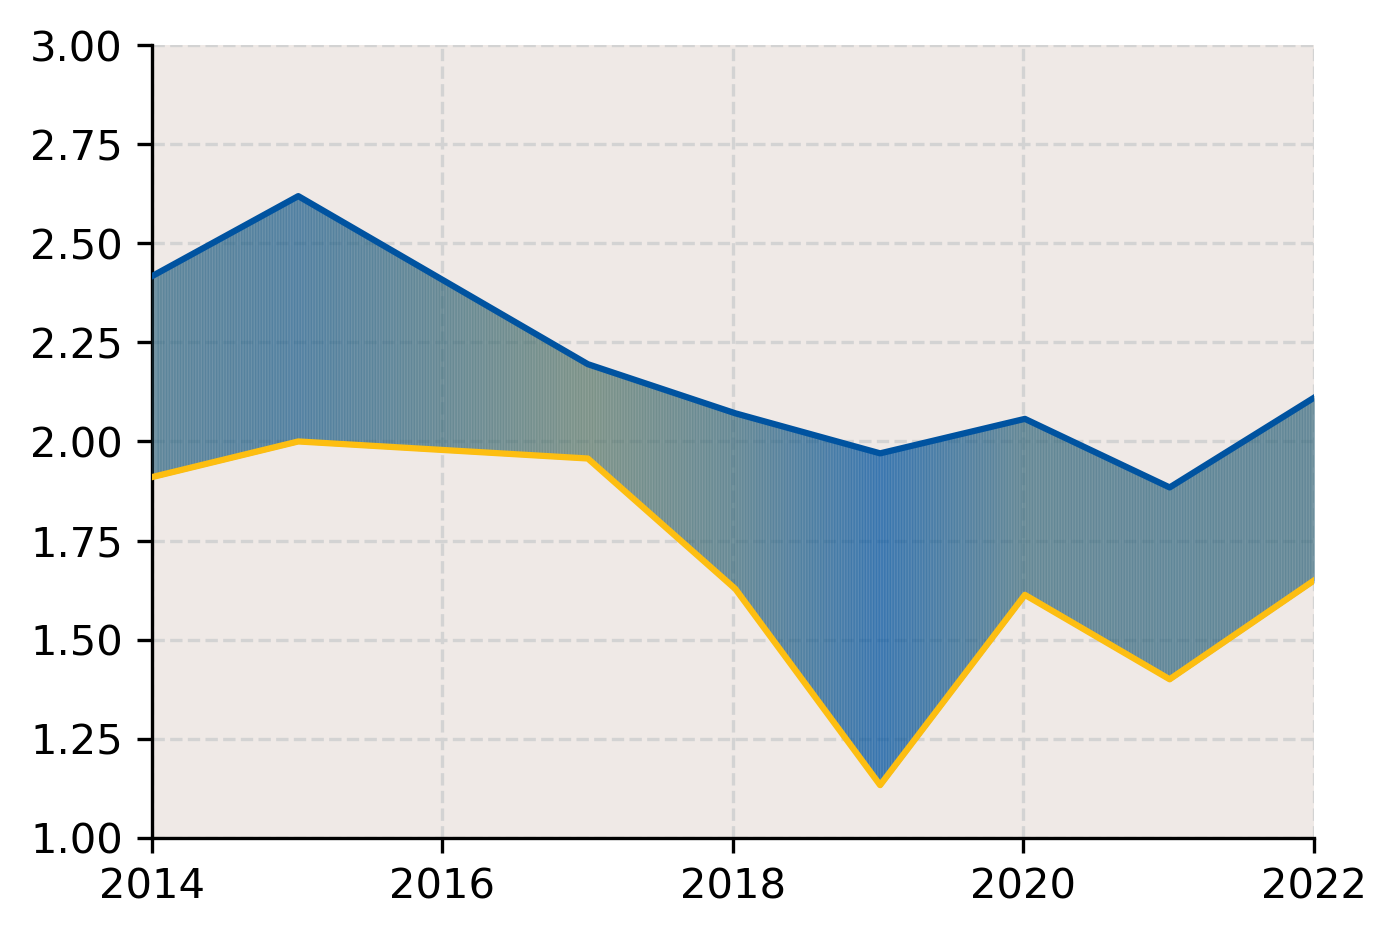

In [240]:
fig = plt.figure(figsize=(5,3.5), dpi=300)
ax = plt.subplot(111)

plot_gradient(ax,'Hampel Jarosław')

In [180]:
list(barwy.keys())

['Zmarzlik Bartosz',
 'Pedersen Nicki',
 'Kołodziej Janusz',
 'Madsen Leon',
 'Vaculik Martin',
 'Pawlicki Piotr',
 'Janowski Maciej',
 'Hampel Jarosław',
 'Holder Chris']

# The final plot

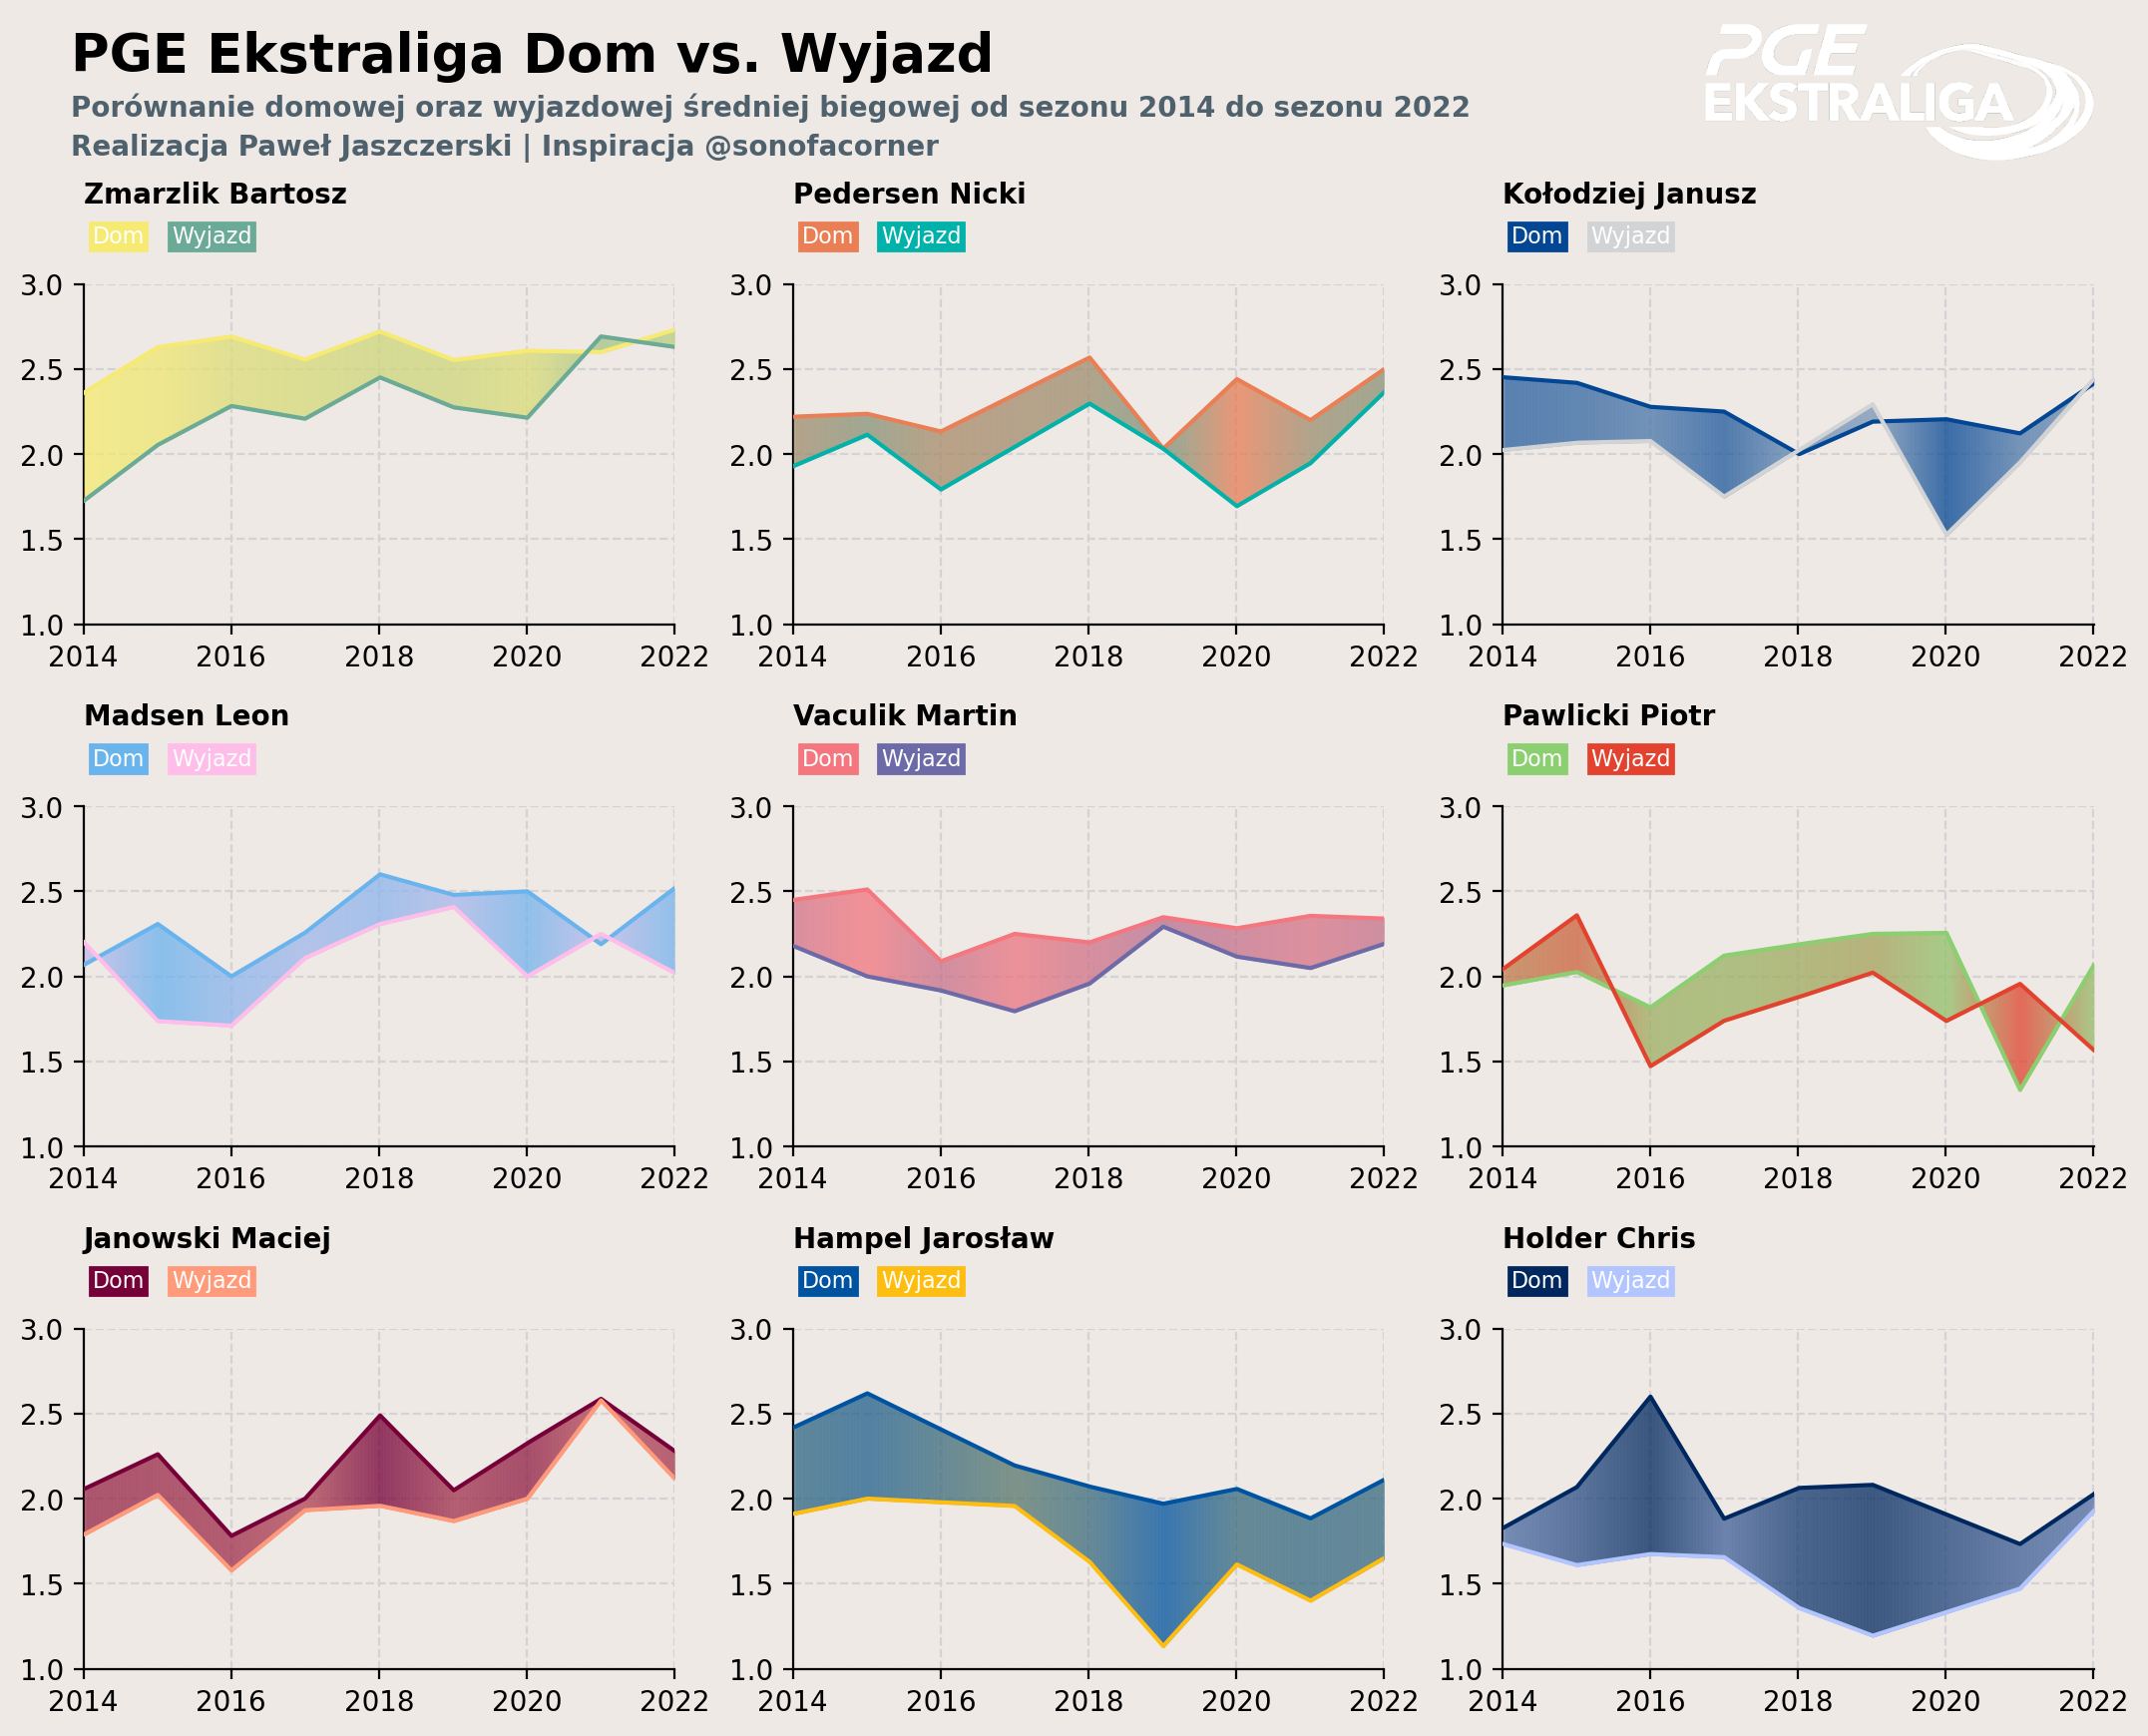

In [305]:
#path effects
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]
pe = path_effect_stroke(linewidth = 1.5, foreground='black')

fig = plt.figure(figsize=(13,10), dpi = 200, facecolor='#EFE9E6')
nrows = 6
ncols = 3
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1/nrows)*2.35 if x % 2 != 0 else (1/nrows)/2.35 for x in range(nrows)], hspace=0.3
)

plot_counter = 0
name_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
            gspec[row,col],
            facecolor = "#EFE9E6"
            )
            rider = list(barwy.keys())[plot_counter]
            plot_gradient(ax,rider)
            plot_counter += 1
        else:
            rider = list(barwy.keys())[name_counter]
            color_1 = barwy[rider]['low']
            color_2 = barwy[rider]['high']
            if color_1 == '#d1d3d4':
                color_1_t == 'black'
            else:
                color_1_t = 'white'
            if color_2 == '#97c1e7':
                color_2_t = 'black'
            else:
                color_2_t = 'white'
            df_text = get_diff(rider)
            riderName = df_text.Zawodnik.iloc[0]
            name_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            name_ax.axis('off')
            #rider name
            ax_text(
                x = 0,
                y = 0.7,
                s = f'<{riderName}>\n <Dom> <|> <Wyjazd>',
                ax = name_ax,
                highlight_textprops=[
                    {'weight':'bold', 'font':'DM Sans'},
                    {'size':'8', 'bbox': {'edgecolor': color_2, 'facecolor': color_2, 'pad': 1}, 'color': color_2_t}, 
                    {'color':'#EFE9E6'},
                    {'size':'8', 'bbox': {'edgecolor': color_1, 'facecolor': color_1, 'pad': 1}, 'color': color_1_t}
                ],
                font = 'Karla', 
                ha = 'left', 
                size = 10, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            
            )
            name_counter +=1
fig_text(
    x=0.12, y=0.92,
    s='PGE Ekstraliga Dom vs. Wyjazd',
    va='bottom', ha='left',
    color='black', size=19,fontweight='black',

)

fig_text(
    x=0.12, y=.88,
    s='Porównanie domowej oraz wyjazdowej średniej biegowej od sezonu 2014 do sezonu 2022 \nRealizacja Paweł Jaszczerski | Inspiracja @sonofacorner',
    va='bottom', ha='left',
    color='#4E616C', size=10, fontweight='bold'

)

league_icon = Image.open("C:/Users/Paweł/Exercises/Power BI/PGE Ekstraliga/pge_ekstraliga_white.png")
league_ax = fig.add_axes([0.75, 0.84, 0.15, 0.15], zorder = 1)
league_ax.imshow(league_icon)
league_ax.axis("off")

plt.savefig(
    "pge_dom_wyj.png",
    dpi = 600,
    facecolor = "#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent = False
)

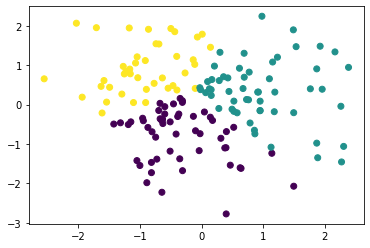

In [243]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# generate random data
np.random.seed(0)
X = np.random.randn(150, 2)

# fit the model
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# get the cluster labels
labels = kmeans.labels_

# plot the data points with different colors for different clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.show()


In [267]:
fm.findSystemFonts(fontpaths=None, fontext='ttf')

['C:\\WINDOWS\\Fonts\\ARLRDBD.TTF',
 'C:\\WINDOWS\\Fonts\\MISTRAL.TTF',
 'C:\\WINDOWS\\Fonts\\Candarab.ttf',
 'C:\\WINDOWS\\Fonts\\consolab.ttf',
 'C:\\WINDOWS\\Fonts\\holomdl2.ttf',
 'C:\\WINDOWS\\Fonts\\segoepr.ttf',
 'C:\\Windows\\Fonts\\gadugib.ttf',
 'C:\\Windows\\Fonts\\LTYPE.TTF',
 'C:\\WINDOWS\\Fonts\\LTYPEBO.TTF',
 'C:\\WINDOWS\\Fonts\\ALGER.TTF',
 'C:\\WINDOWS\\Fonts\\GLSNECB.TTF',
 'C:\\Windows\\Fonts\\constani.ttf',
 'C:\\WINDOWS\\Fonts\\LHANDW.TTF',
 'C:\\WINDOWS\\Fonts\\l_10646.ttf',
 'C:\\Windows\\Fonts\\JUICE___.TTF',
 'C:\\WINDOWS\\Fonts\\VIVALDII.TTF',
 'C:\\WINDOWS\\Fonts\\BRADHITC.TTF',
 'C:\\Windows\\Fonts\\ENGR.TTF',
 'C:\\WINDOWS\\Fonts\\trebucbd.ttf',
 'C:\\Windows\\Fonts\\pala.ttf',
 'C:\\Windows\\Fonts\\sylfaen.ttf',
 'C:\\WINDOWS\\Fonts\\gadugib.ttf',
 'C:\\WINDOWS\\Fonts\\CENSCBK.TTF',
 'C:\\Windows\\Fonts\\CENSCBK.TTF',
 'C:\\WINDOWS\\Fonts\\DUBAI-MEDIUM.TTF',
 'C:\\WINDOWS\\Fonts\\timesbi.ttf',
 'C:\\Windows\\Fonts\\YuGothM.ttc',
 'C:\\Windows\\Fonts\\STEN

In [274]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
fpath = Path(mpl.get_data_path(),'C:/Users/Paweł/AppData/Local/Microsoft/Windows/Fonts/KarlaLight.ttf')
fpath2 = Path(mpl.get_data_path(),'C:/Users/Paweł/AppData/Local/Microsoft/Windows/Fonts/DMSansRegular.ttf')